In [1]:
import warnings
from importlib import reload
from functools import partial, lru_cache
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm, trange
from joblib import delayed
from modAL import batch
from art.metrics import empirical_robustness
from art.attacks.evasion import *
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tabulate import tabulate
from art.estimators.classification.scikitlearn import ScikitlearnSVC
from sklearn.metrics.pairwise import paired_distances, euclidean_distances
import scipy
from tvregdiff.tvregdiff import TVRegDiff

import ipywidgets as widgets
from ipywidgets import interact
from ipynb.fs.defs import Bias
from ipynb.fs.defs.Datasets import generateData_twoPills_2D, generateData_twoPills_noNoise_2D, plot_dataset_2D

import libactive
import libadversarial
import libstop
from libactive import MyActiveLearner, active_split
from libadversarial import adversarial, uncertainty, random_batch, uncertainty_stop
from libutil import ProgressParallel
from libdatasets import *
import librun
from librun import run
from libplot import align_yaxis

In [2]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("bbbp", lambda: lru_cache()(bbbp)()),
        ("car", lambda: lru_cache()(car)()),
        ("mnist", lambda: lru_cache()(mnist)()),
        ("german", lambda: lru_cache()(german)()),
    ],
    "dataset_mutators": {
        "none": (lambda *x: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 0.01,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        #"aggregate": False
    }
}

In [3]:
capture_metrics = [
    accuracy_score,
    f1_score,
    roc_auc_score,
    
    "uncertainty_average",
    "uncertainty_min",
    "uncertainty_max",
    "uncertainty_variance",
    "uncertainty_average_selected",
    "uncertainty_min_selected",
    "uncertainty_max_selected",
    "uncertainty_variance_selected",
    "entropy_max",
    "n_support",
    "contradictory_information",
    # slow, run this on the VM over the weekend!
    #"expected_error"
]

In [4]:
results = librun.run(matrix, metrics=capture_metrics, force_cache=True)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

In [5]:
reload(libstop); from libstop import ZPS, uncertainty_min, n_support, optimal, optimal_ub, optimal_lb, optimal_fixed, SC_entropy_mcs, SC_oracle_acc_mcs, acc, first_acc, EVM, kappa, kappa_metric, no_ahead_tvregdiff, hyperplane_similarity

In [6]:
params = {
    "kappa": {"k": 2}
}
stop_conditions = {
    #f"{f.__name__}": partial(f, **params.get(f.__name__, {})) for f in [ZPS, uncertainty_min, n_support, optimal, optimal_ub, optimal_lb, SC_entropy_mcs, SC_oracle_acc_mcs, EVM, ]#kappa]
    **{f"{f.__name__}": partial(f, **params.get(f.__name__, {})) for f in [ZPS, uncertainty_min, n_support, SC_entropy_mcs, SC_oracle_acc_mcs, EVM]},
    #"ZPS2": partial(ZPS, order=2)
}

In [9]:
stop_results = {}
for (clfs, (conf, metrics)) in zip(classifiers, results_plots):
    stop_results[conf.dataset_name] = {}
    for (name, cond) in stop_conditions.items():
        stop_results[conf.dataset_name][name] = [cond(**metrics, classifiers=clfs_) for clfs_ in clfs]

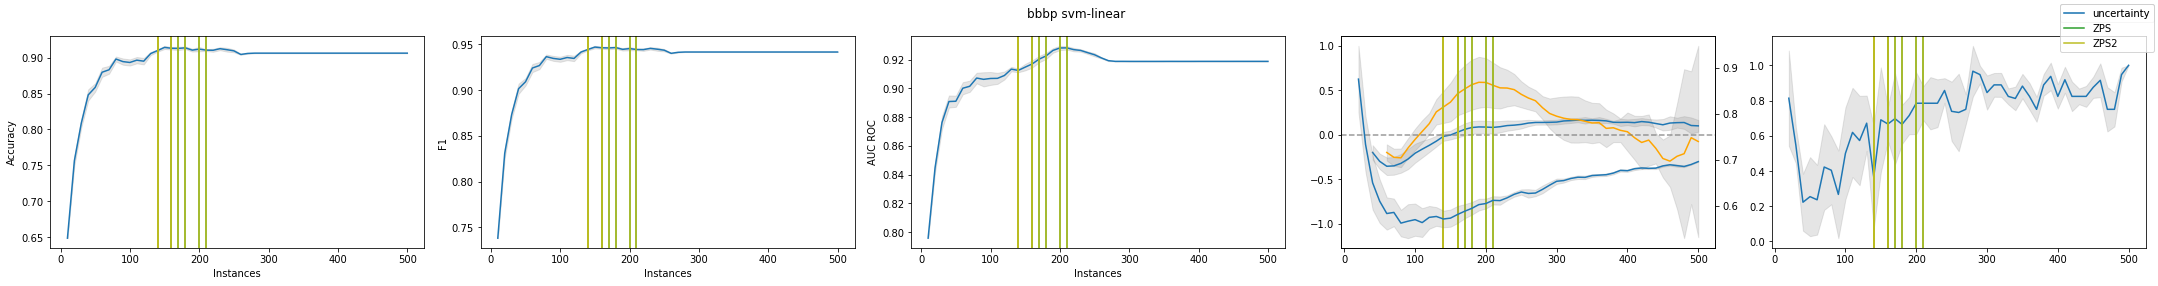

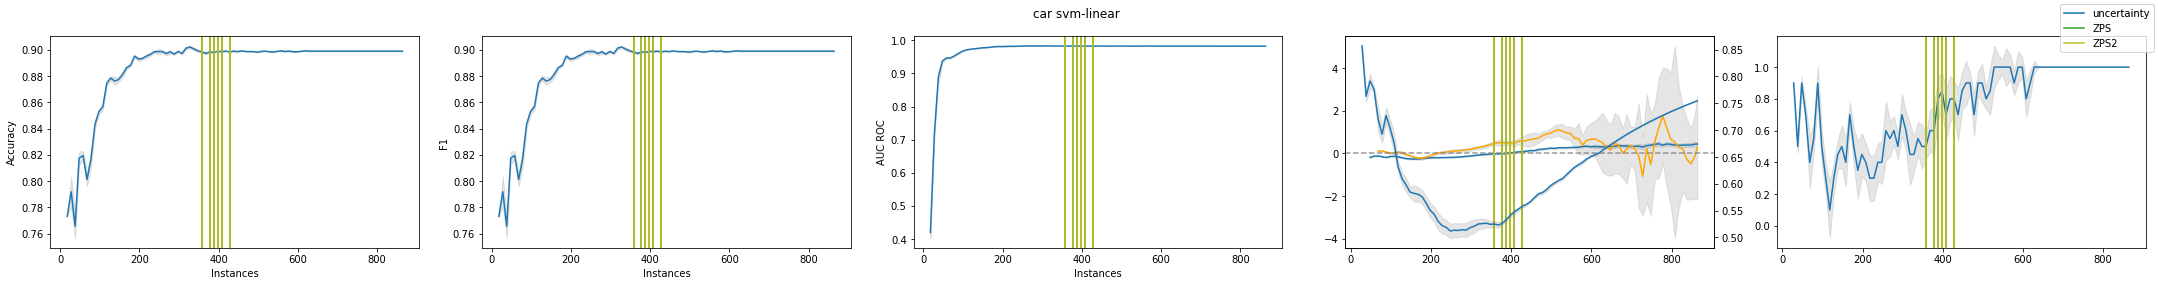

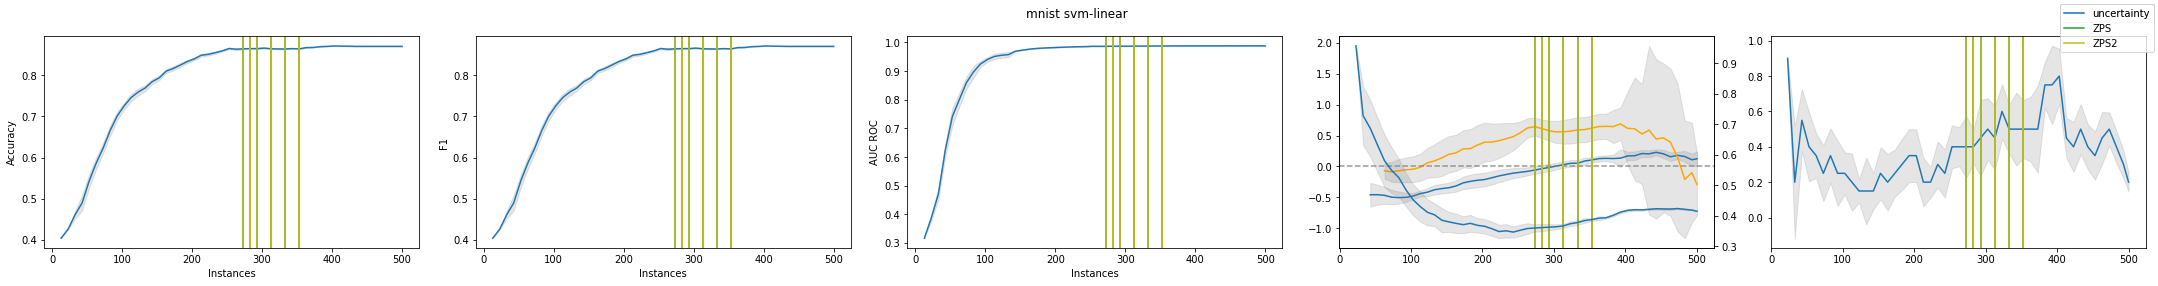

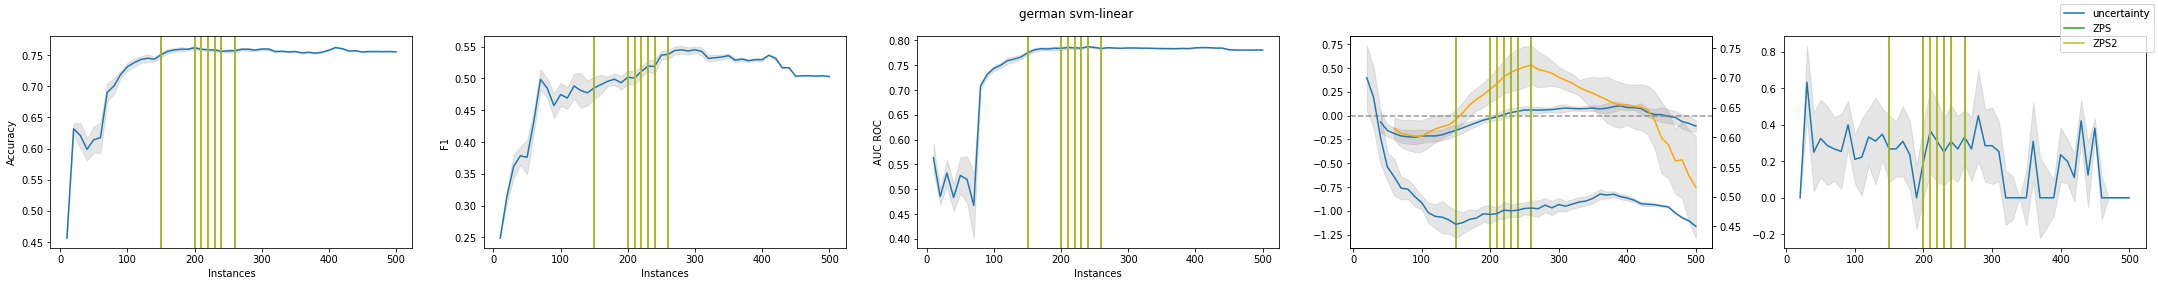

In [113]:
reload(libstop); reload(librun)
figaxes = librun.plot(results_plots, ret=True, sort=False, extra=2, figsize=(30,4))
for i, (fig, ax) in enumerate(figaxes):
    clfs = classifiers[i]
    metrics = results_plots[i][1]
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    ax2 = ax[-2].twinx()
    accs = [first_acc(clfs_)[1] for clfs_ in clfs]
    accx = first_acc(clfs[0])[0]
    
    acc_median = np.median(accs, axis=0)
    acc_stderr = np.std(accs, axis=0)
    
    # best params so far:
    # * 1
    # * 1e-1
    # 
    acc_grad = [no_ahead_tvregdiff(acc_, 1, 1e-1, plotflag=False, diagflag=False) for acc_ in accs]
    acc_grad_median = np.median(acc_grad, axis=0)
    acc_grad_stderr = np.std(acc_grad, axis=0)
    
    firsts = [no_ahead_tvregdiff(acc_, 1, 1e-1, plotflag=False, diagflag=False) for acc_ in accs]
    acc_grad2 = [no_ahead_tvregdiff(first[2:], 1, 1e-1, plotflag=False, diagflag=False) for first in firsts]

    acc_grad_median2 = np.median(acc_grad2, axis=0)
    acc_grad_stderr2 = np.std(acc_grad2, axis=0)
    
    ax2.plot(accx, acc_median)
    ax2.fill_between(accx, acc_median-acc_stderr, acc_median+acc_stderr, color='grey', alpha=0.2)
    
    ax[-2].plot(accx, acc_grad_median)
    ax[-2].fill_between(accx, acc_grad_median-acc_grad_stderr, acc_grad_median+acc_grad_stderr, color='grey', alpha=0.2)
    
    ax[-2].plot(accx[2:], acc_grad_median2, color='orange')
    ax[-2].fill_between(accx[2:], acc_grad_median2-acc_grad_stderr2, acc_grad_median2+acc_grad_stderr2, color='grey', alpha=0.2)

    ax[-2].axhline(0, ls='--', color='grey', alpha=0.8)
    
    rocs = [first_acc(clfs_, metric=f1_score)[1] for clfs_ in clfs]
    rocsx = first_acc(clfs[0], metric=f1_score)[0]
    
    roc_median = np.median(rocs, axis=0)
    roc_stderr = np.std(rocs, axis=0)
    
    ax[-1].plot(rocsx, roc_median)
    ax[-1].fill_between(rocsx, roc_median-roc_stderr, roc_median+roc_stderr, color='grey', alpha=0.2)
    
    for ii, a in enumerate(ax):        
        for iii, (name, cond) in enumerate(stop_conditions.items()):
            stops = stop_results[results_plots[i][0].dataset_name][name]
            #a.axvline(np.median(stops), label=name if ii == 0 else None, color=colors[(iii+1)%len(colors)])
            if name not in ["ZPS", "ZPS2"]:
                continue
            for iiii, stop in enumerate(stops):
                a.axvline(stop, label=name if ii == 0 and iiii ==0 else None, color=colors[(iii+1) % len(colors)])

    fig.legend()
    fig.tight_layout()

### Report plot (temporary)

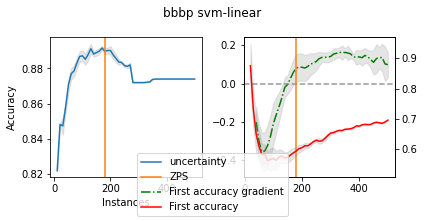

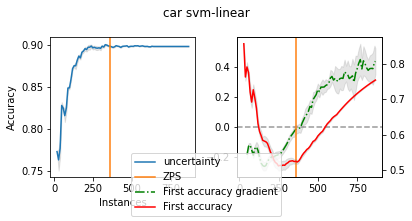

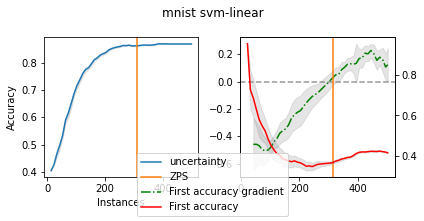

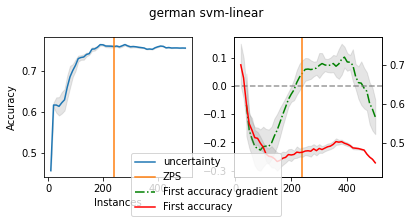

In [14]:
from itertools import groupby
def plot(results, plot_robustness=False, key=None, series=None, title=None, ret=False, sort=True, figsize=(8,4), extra=0):
    if key is None:
        key = lambda config_result: (
            config_result[0].dataset_name,
            config_result[0].dataset_mutator_name,
            getattr(config_result[0], "model_name", None),
        )
    if series is None:
        series = lambda config: config.method_name
    if title is None:
        title = lambda config: f"{config.dataset_name} {config.model_name}"
    if sort:
        results = sorted(results, key=key)
    groups = groupby(results, key)
    figaxes = []
    for k, group in groups:
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        figaxes.append((fig, axes))

        for config, result in group:
            for i, ax in enumerate(axes.flatten()[:-extra if extra != 0 else len(axes.flatten())]):
                if i != 0:
                    continue
                try:
                    i_stderr = result.columns.get_loc("accuracy_score_stderr")
                    has_stderr = True
                except KeyError:
                    has_stderr = False
                if len(result["x"] > 100):
                    ax.plot(
                        result["x"],
                        result.iloc[:, 1 + i],
                        "-",
                        label=f"{series(config)}" if i == 0 else "",
                    )
                    if has_stderr:
                        ax.fill_between(
                            result["x"],
                            result.iloc[:, 1 + i] - result.iloc[:, i_stderr + i],
                            result.iloc[:, 1 + i] + result.iloc[:, i_stderr + i],
                            color="grey",
                            alpha=0.2,
                        )
                else:
                    ax.errorbar(
                        result["x"],
                        result.iloc[:, 1 + i],
                        yerr=result.iloc[:, i_stderr + i] if has_stderr else None,
                        label=f"{series(config)}" if i == 0 else "",
                    )
                ax.set_xlabel("Instances")
                ax.set_ylabel(["Accuracy", "F1", "AUC ROC", "Empirical Robustness"][i])
                plt.suptitle(title(config))

        #fig.legend()
    if ret:
        return figaxes

figaxes = plot(results_plots, ret=True, sort=False, extra=1, figsize=(6,3))
for i, (fig, ax) in enumerate(figaxes):
    clfs = classifiers[i]
    metrics = results_plots[i][1]
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    ax2 = ax[-1].twinx()
    accs = [first_acc(clfs_)[1] for clfs_ in clfs]
    accx = first_acc(clfs[0])[0]
    
    acc_median = np.median(accs, axis=0)
    acc_stderr = np.std(accs, axis=0)
    
    # best params so far:
    # * 1
    # * 1e-1
    # 
    acc_grad = [no_ahead_tvregdiff(acc_, 1, 1e-1, plotflag=False, diagflag=False) for acc_ in accs]
    acc_grad_median = np.median(acc_grad, axis=0)
    acc_grad_stderr = np.std(acc_grad, axis=0)
    
    #firsts = [no_ahead_tvregdiff(acc_, 1, 1e-1, plotflag=False, diagflag=False) for acc_ in accs]
    #acc_grad2 = [no_ahead_tvregdiff(first[2:], 1, 1e-1, plotflag=False, diagflag=False) for first in firsts]

    #acc_grad_median2 = np.median(acc_grad2, axis=0)
    #acc_grad_stderr2 = np.std(acc_grad2, axis=0)
    
    ax2.plot(accx, acc_median, label='First accuracy', color='red')
    ax2.fill_between(accx, acc_median-acc_stderr, acc_median+acc_stderr, color='grey', alpha=0.2)
    
    ax[-1].plot(accx, acc_grad_median, label='First accuracy gradient', color='green', ls='-.')
    ax[-1].fill_between(accx, acc_grad_median-acc_grad_stderr, acc_grad_median+acc_grad_stderr, color='grey', alpha=0.2)

   # ax[-2].plot(accx[2:], acc_grad_median2, color='orange')
    #ax[-2].fill_between(accx[2:], acc_grad_median2-acc_grad_stderr2, acc_grad_median2+acc_grad_stderr2, color='grey', alpha=0.2)

    ax[-1].axhline(0, ls='--', color='grey', alpha=0.8)
    
    #rocs = [first_acc(clfs_, metric=f1_score)[1] for clfs_ in clfs]
    #rocsx = first_acc(clfs[0], metric=f1_score)[0]
    
    #roc_median = np.median(rocs, axis=0)
    #roc_stderr = np.std(rocs, axis=0)
    
    #ax[-1].plot(rocsx, roc_median)
    #ax[-1].fill_between(rocsx, roc_median-roc_stderr, roc_median+roc_stderr, color='grey', alpha=0.2)
    
    #ax[-1].legend()
    #ax[-2].legend()
    
    for ii, a in enumerate(ax):        
        for iii, (name, cond) in enumerate(stop_conditions.items()):
            stops = stop_results[results_plots[i][0].dataset_name][name]
            #a.axvline(np.median(stops), label=name if ii == 0 else None, color=colors[(iii+1)%len(colors)])
            if name not in ["ZPS", "ZPS2"]:
                continue
            for iiii, stop in enumerate(stops[:1]):
                a.axvline(stop, label=name if ii == 0 and iiii ==0 else None, color=colors[(iii+1) % len(colors)])

    fig.legend(loc='lower center')
    fig.tight_layout()

## Broken metric plot

C:\Users\Zac\Programming\python\research\librun.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, (4 if plot_robustness else 3)+extra, figsize=figsize)


ValueError: x and y must have same first dimension, but have shapes (49,) and (50, 1)

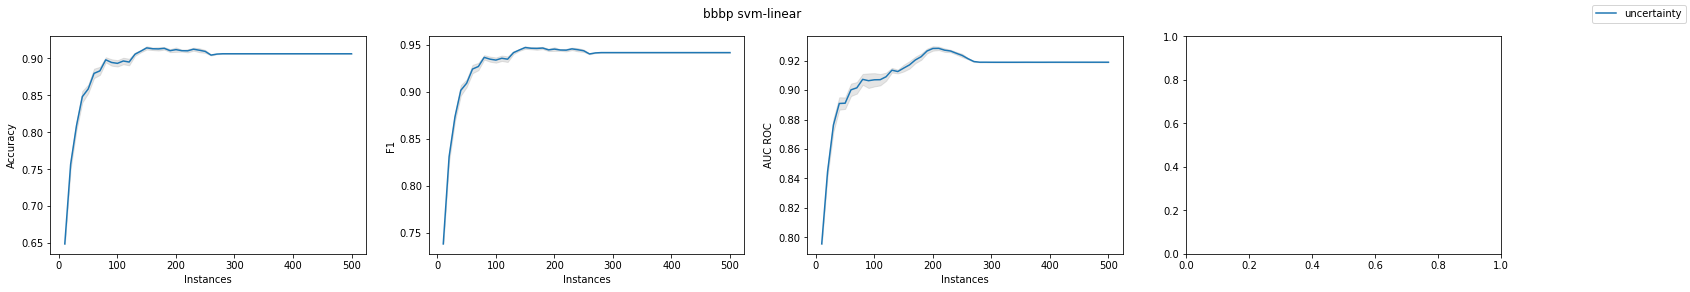

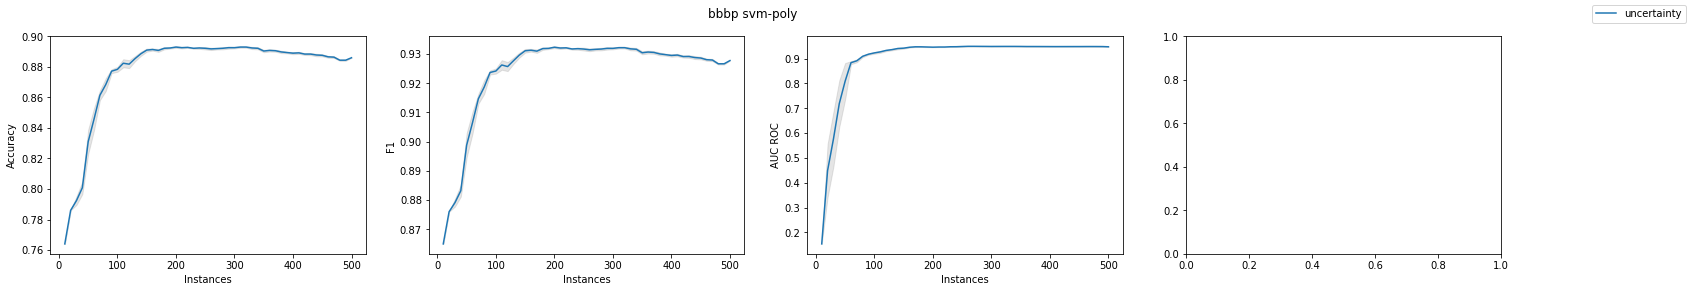

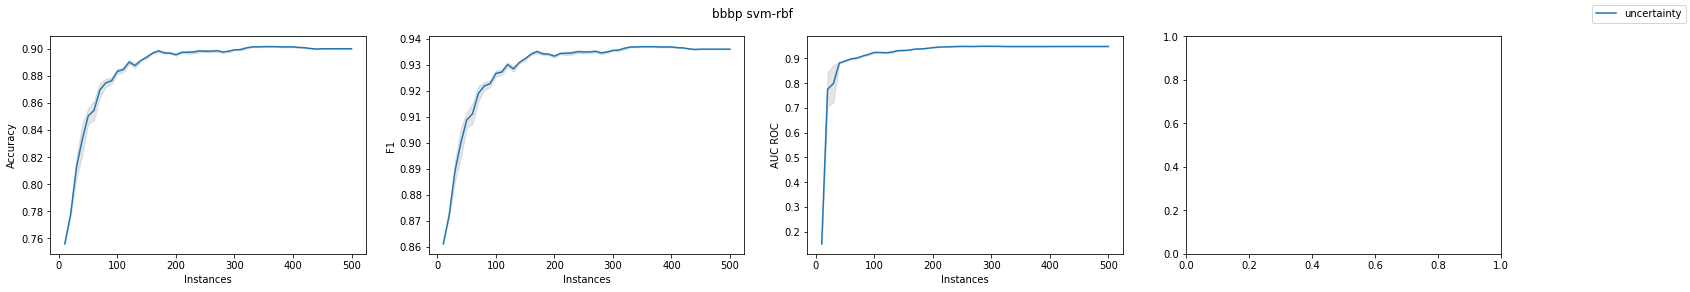

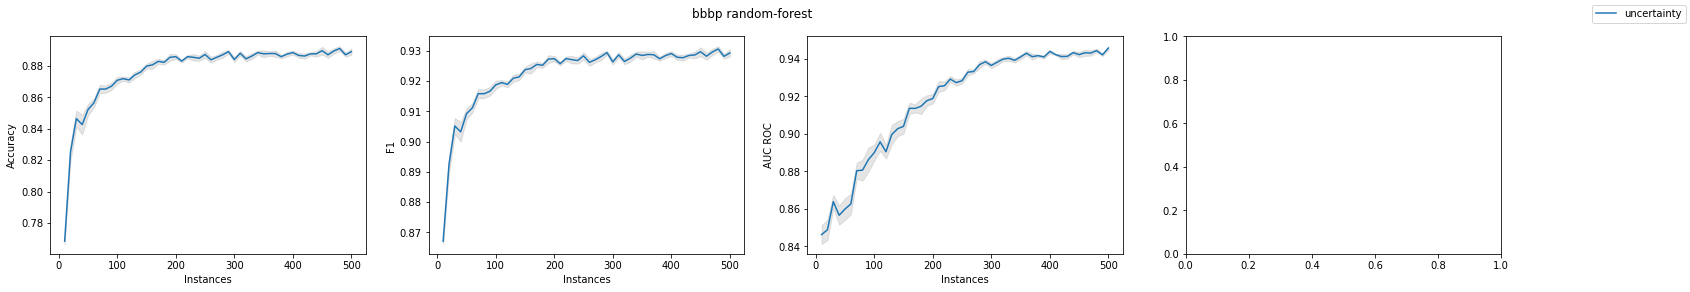

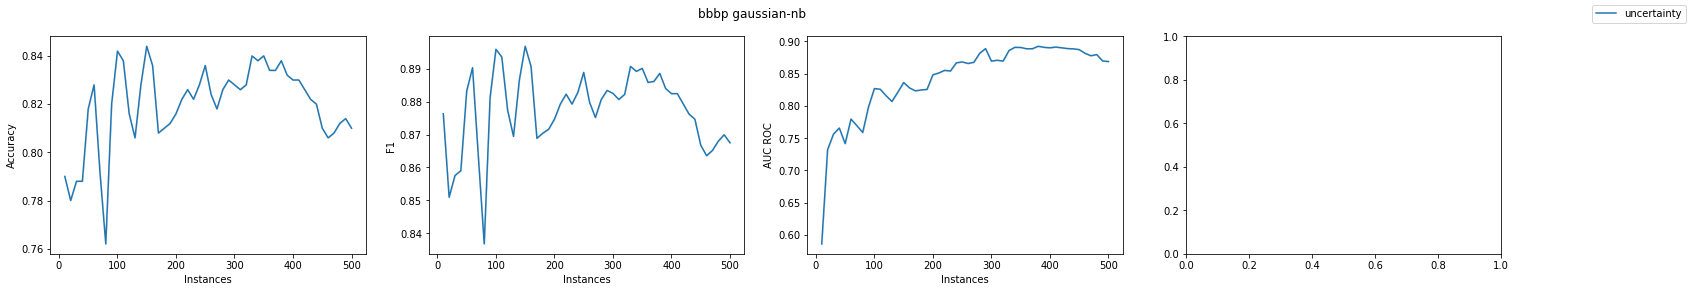

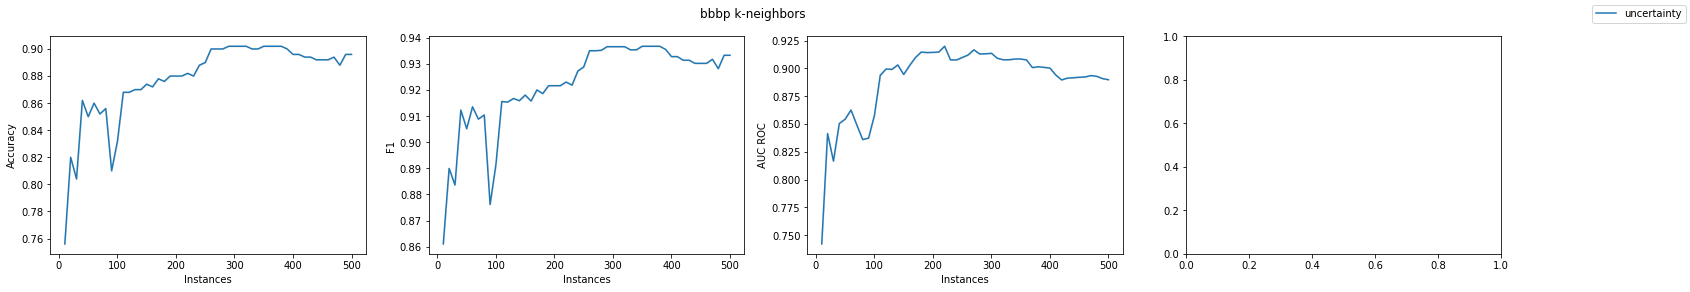

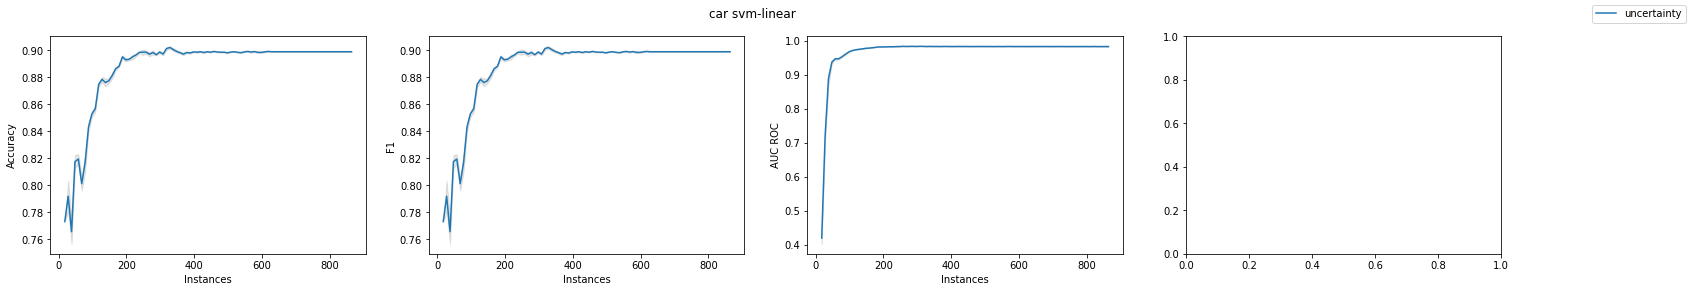

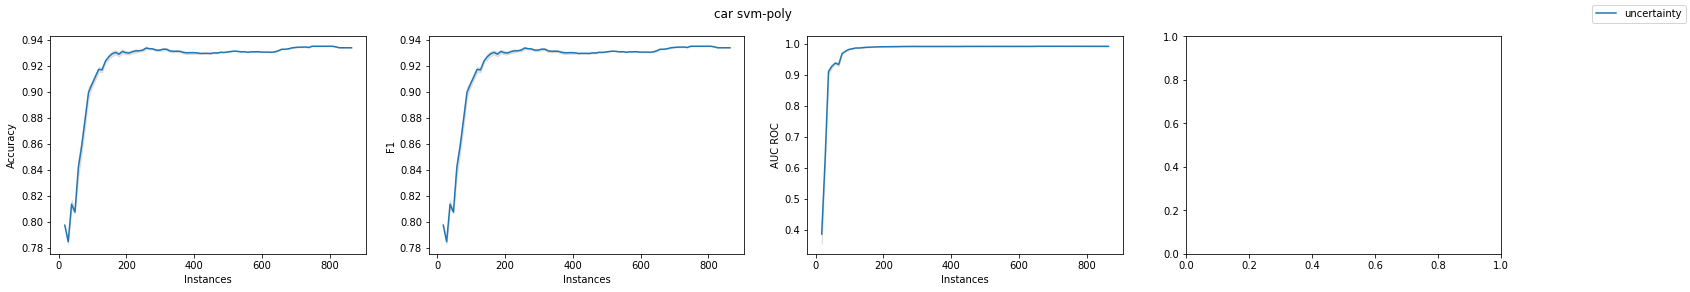

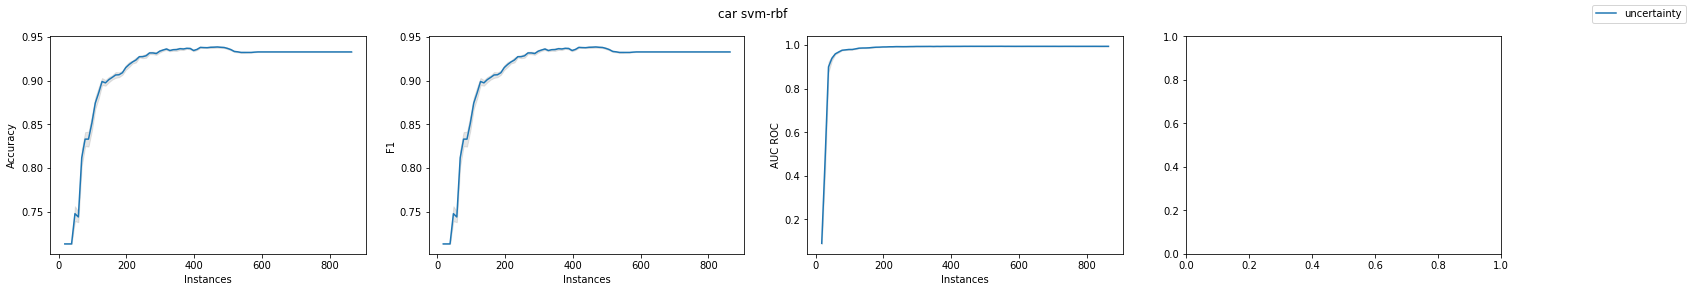

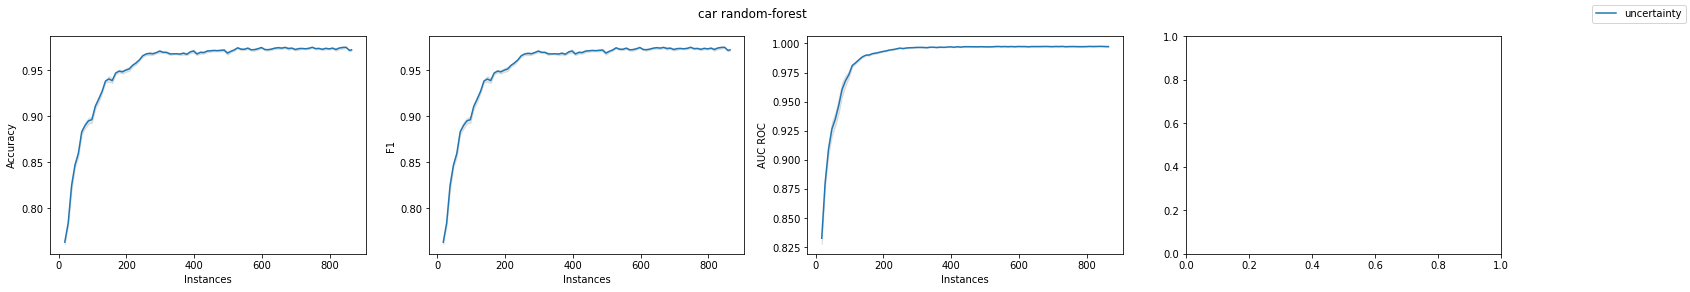

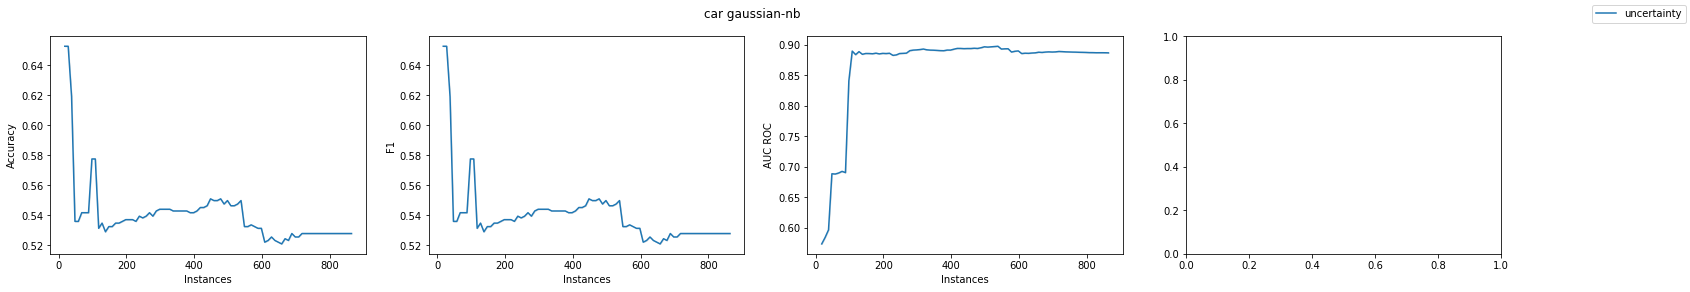

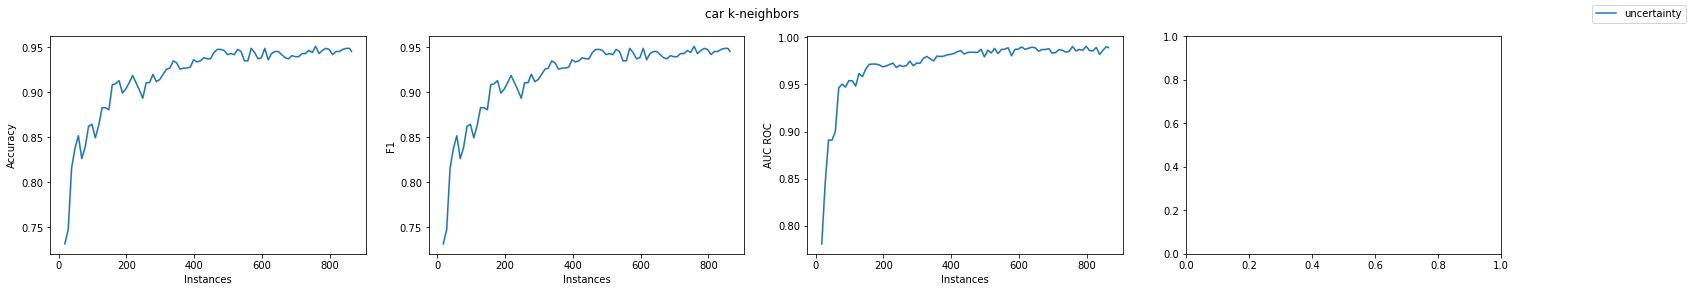

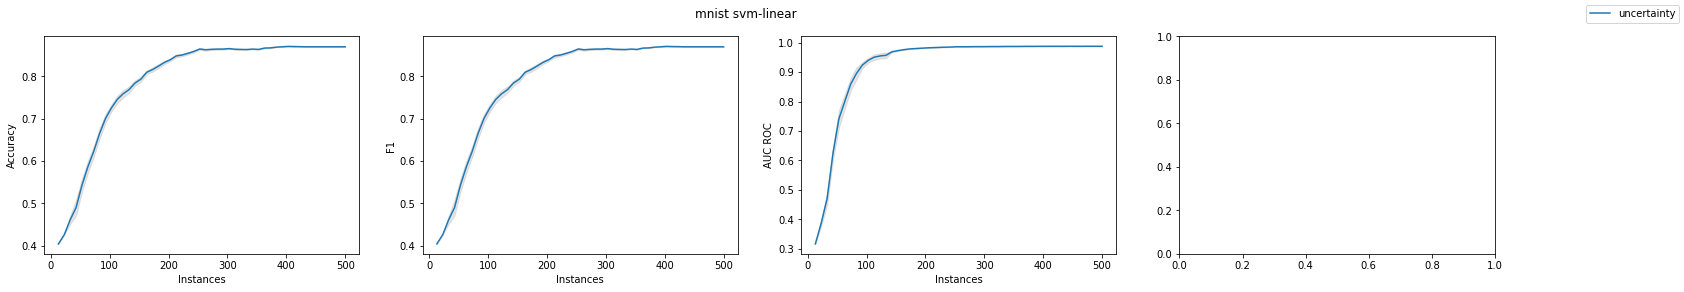

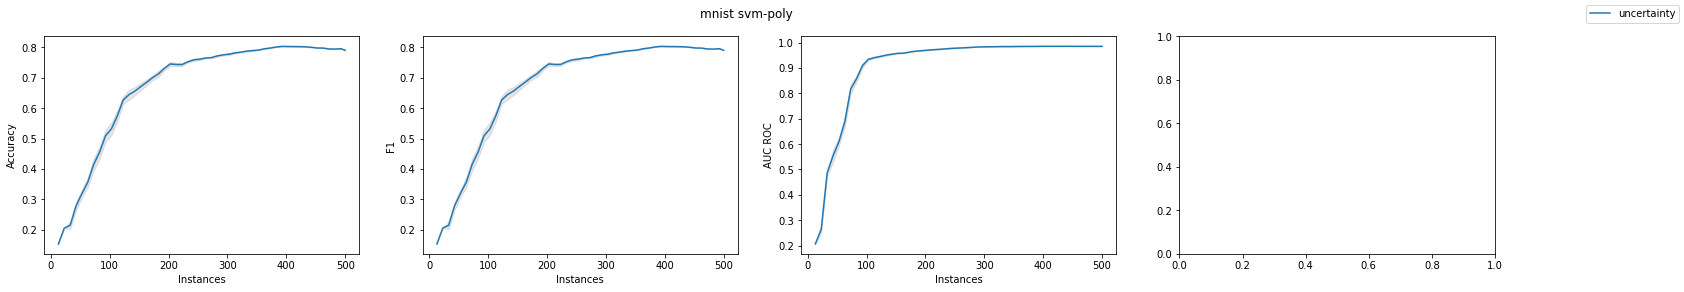

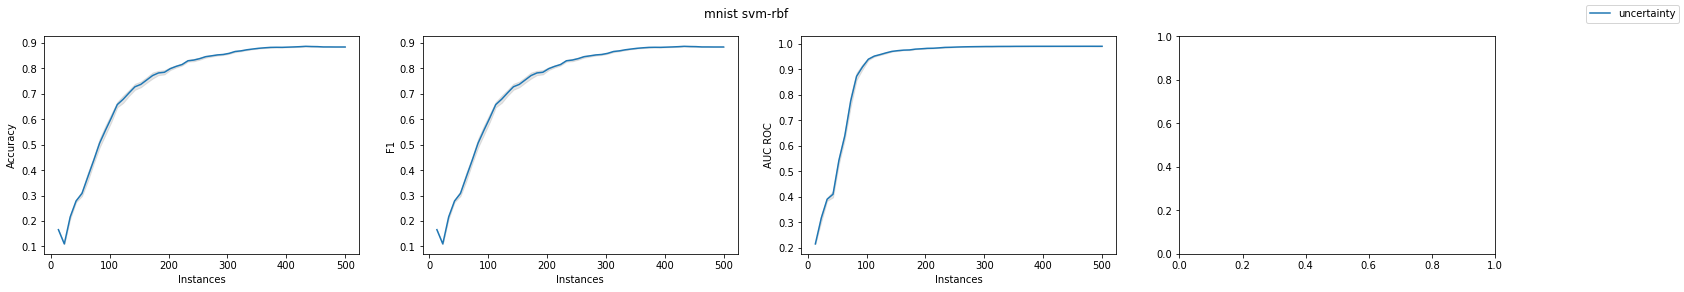

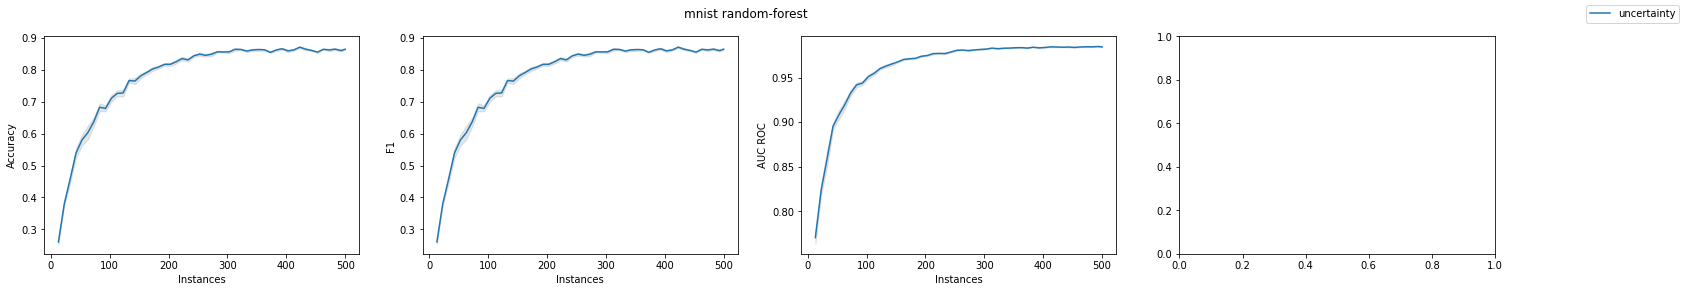

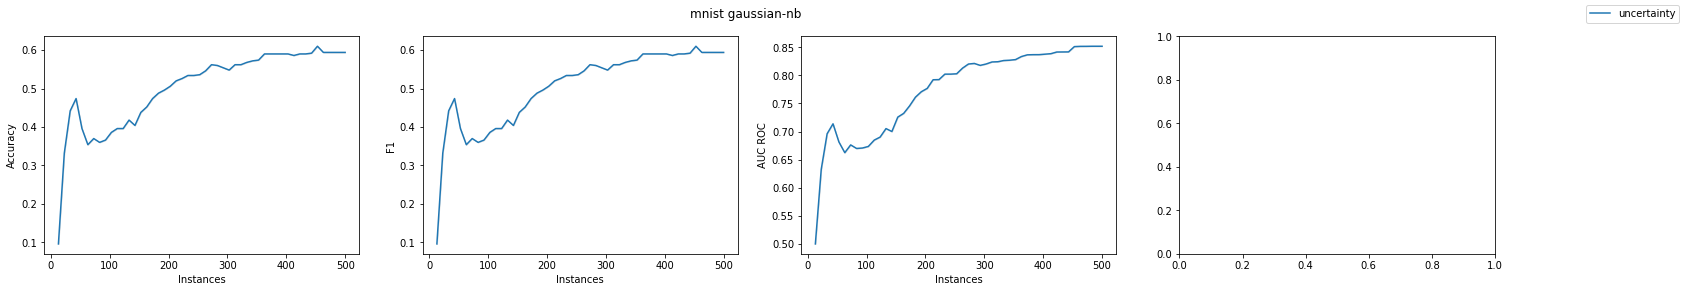

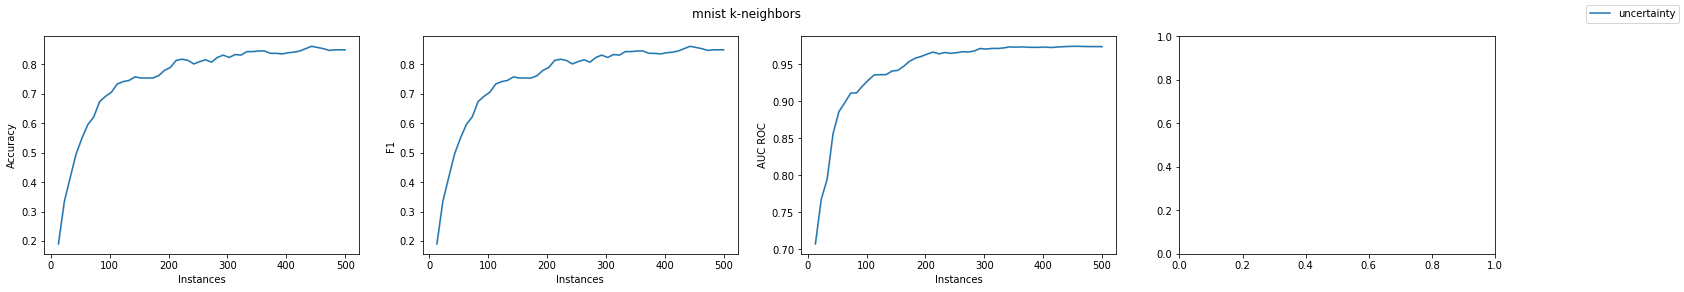

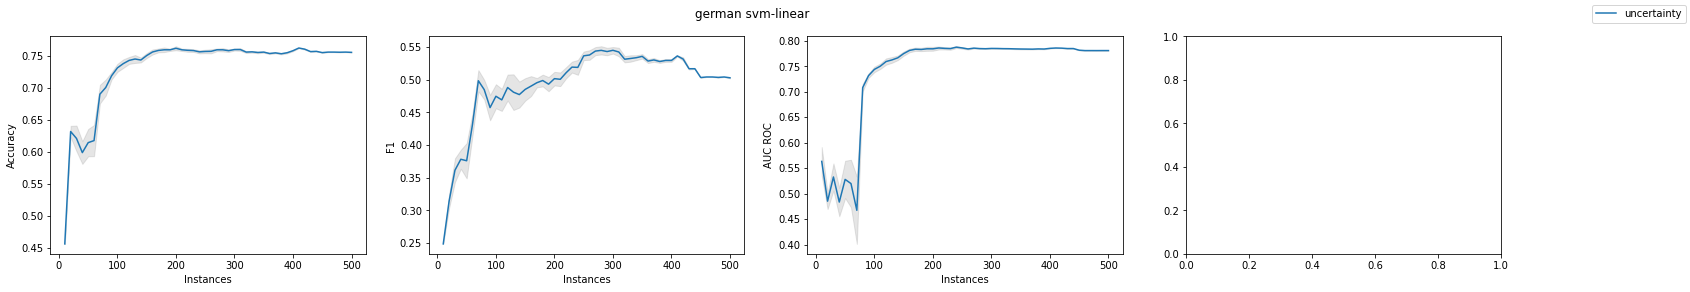

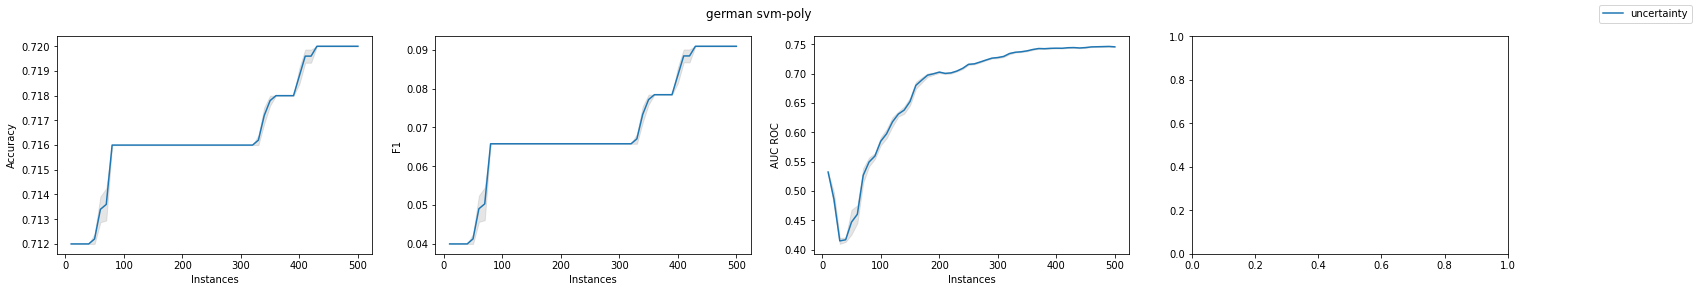

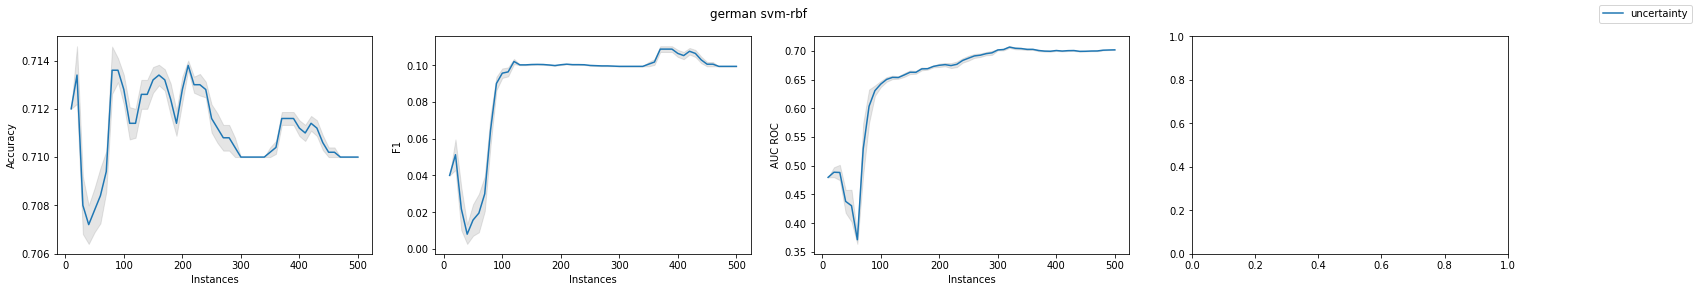

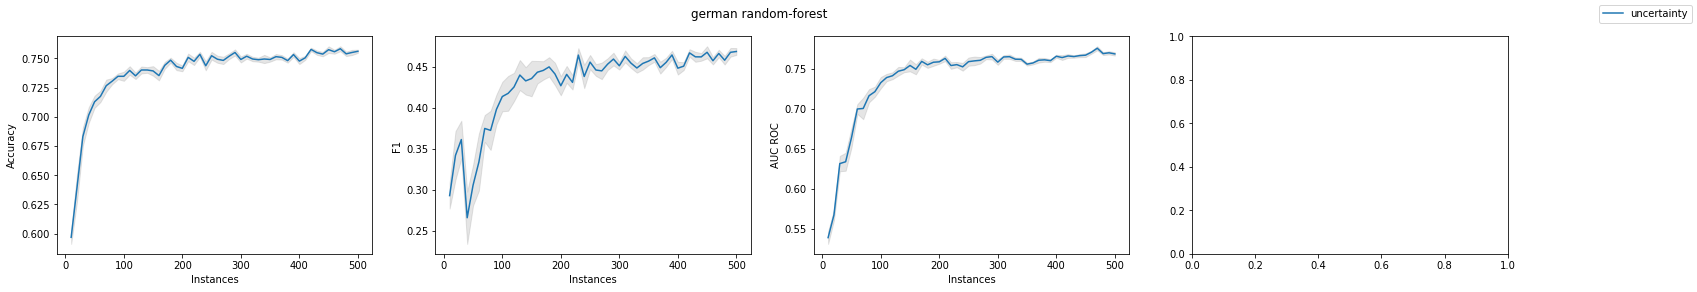

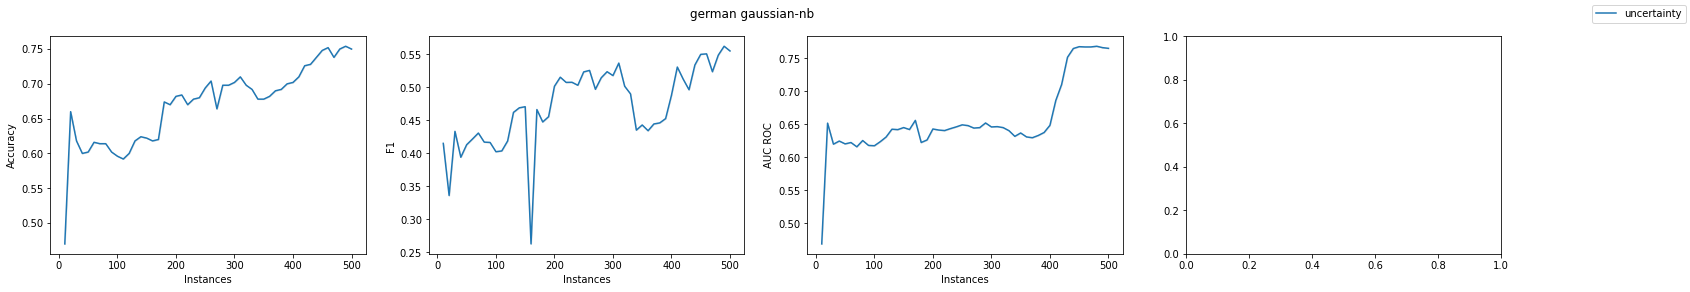

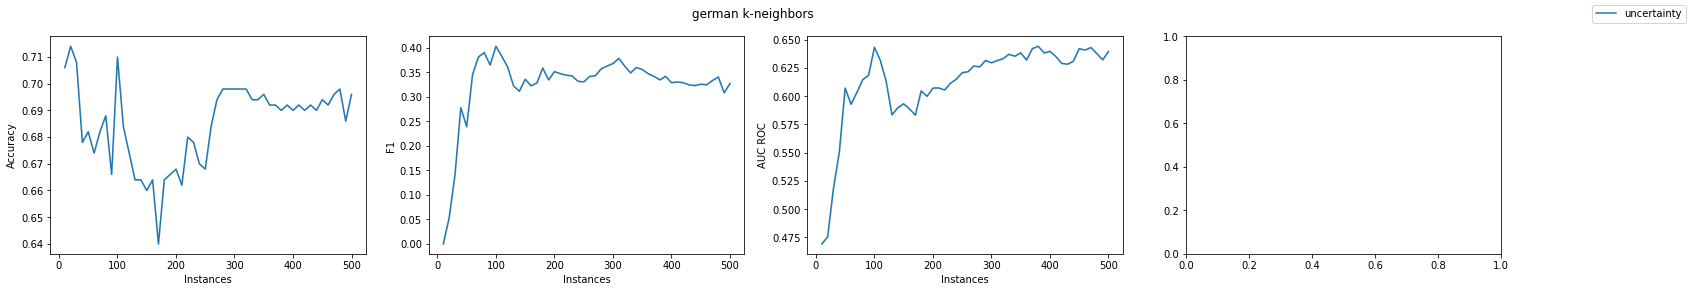

In [51]:
reload(libstop); reload(librun)
figaxes = librun.plot(results_plots, ret=True, sort=False, extra=1, figsize=(26,4))
for i, (fig, ax) in enumerate(figaxes):
    clfs = classifiers[i]
    metrics = results_plots[i][1]
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    accs = [first_acc(clfs_)[1] for clfs_ in clfs]
    accx = first_acc(clfs[0])[0]
    
    acc_median = np.median(accs, axis=0)
    acc_stderr = np.std(accs, axis=0)
    
    ax[-1].plot(accx, hyperplane_similarity(clfs[0]))
    #ax[-1].fill_between(accx, acc_median-acc_stderr, acc_median+acc_stderr, color='grey', alpha=0.2)
    
    #for j in range(1,5):
    #    x, y = acc(clfs[0], nth=j)
    #    ax[-1].plot(x, y)
    
    for ii, a in enumerate(ax):        
        for iii, (name, cond) in enumerate(stop_conditions.items()):
            stops = stop_results[results_plots[i][0].dataset_name][name]
            #a.axvline(np.median(stops), label=name if ii == 0 else None, color=colors[(iii+1)%len(colors)])
            if name not in ["ZPS", "ZPS2"]:
                continue
            for iiii, stop in enumerate(stops):
                a.axvline(stop, label=name if ii == 0 and iiii ==0 else None, color=colors[(iii+1) % len(colors)])

    fig.legend()
    fig.tight_layout()

## Observations

* Accuracy is much better than ROC AUC or F1 for this. It's strange that it is the only metric which follows the pattern.
* Second derivatives may be useful to avoid stopping early, but otherwise are not of predictive value
* The method could be made slightly more aggressive by stopping at an accuracy gradient of <= ~ -0.2
* Likewise it could be made slightly more conservative by stopping at an accuracy gradient of <= ~0.2
* It could be modified to skip dips if a supervisor deemed it too soon to stop.
* pynumdiff does not appear to give good results as it smoothes the input too much, this may be adjustable but it is not obvious

In [11]:
reload(libstop); from libstop import stopped_at, optimal_dist, in_bounds, performance

In [36]:
stopped_at(stop_results)

╒════════╤═════════════════╤═══════════════╤═══════════════════╤═══════════════╤══════════════════╤═════════════════════╤═══════════════╕
│        │ optimal_fixed   │ ZPS           │ uncertainty_min   │ n_support     │ SC_entropy_mcs   │ SC_oracle_acc_mcs   │ EVM           │
╞════════╪═════════════════╪═══════════════╪═══════════════════╪═══════════════╪══════════════════╪═════════════════════╪═══════════════╡
│ bbbp   │ 170, 170, 170   │ 80, 110, 160  │ 50, 50, 50        │ 310, 310, 310 │ 500, 500, 500    │ 30, 150, 200        │ 170, 170, 170 │
├────────┼─────────────────┼───────────────┼───────────────────┼───────────────┼──────────────────┼─────────────────────┼───────────────┤
│ car    │ 188, 188, 188   │ 108, 318, 398 │ 88, 88, 88        │ 658, 658, 658 │ 738, 738, 738    │ 48, 58, 118         │ 98, 98, 98    │
├────────┼─────────────────┼───────────────┼───────────────────┼───────────────┼──────────────────┼─────────────────────┼───────────────┤
│ mnist  │ 253, 253, 253   │ 213, 

In [55]:
optimal_dist(stop_results, optimal='optimal_fixed')

╒════════╤══════════════════════╤════════════════════╤═════════════════════╤══════════════════════╤══════════════════════╤══════════════════════╕
│        │ ZPS                  │ uncertainty_min    │ n_support           │ SC_entropy_mcs       │ SC_oracle_acc_mcs    │ EVM                  │
╞════════╪══════════════════════╪════════════════════╪═════════════════════╪══════════════════════╪══════════════════════╪══════════════════════╡
│ bbbp   │ -90, -60, -10        │ -120, -120, -120   │ 140, 140, 140       │ 330, 330, 330        │ -140, -20, 30        │ 0, 0, 0              │
├────────┼──────────────────────┼────────────────────┼─────────────────────┼──────────────────────┼──────────────────────┼──────────────────────┤
│ car    │ -80, 130, 210        │ -100, -100, -100   │ 470, 470, 470       │ 550, 550, 550        │ -140, -130, -70      │ -90, -90, -90        │
├────────┼──────────────────────┼────────────────────┼─────────────────────┼──────────────────────┼──────────────────────┼──

In [93]:
performance(stop_results, results_plots, metric='roc_auc_score')

╒════════╤═════════════════╤═══════╤═══════════════════╤═════════════╤══════════════════╤═════════════════════╤═══════╕
│        │ optimal_fixed   │ ZPS   │ uncertainty_min   │ n_support   │ SC_entropy_mcs   │ SC_oracle_acc_mcs   │ EVM   │
╞════════╪═════════════════╪═══════╪═══════════════════╪═════════════╪══════════════════╪═════════════════════╪═══════╡
│ bbbp   │ 99%             │ 98%   │ 96%               │ 99%         │ 99%              │ 99%                 │ 99%   │
├────────┼─────────────────┼───────┼───────────────────┼─────────────┼──────────────────┼─────────────────────┼───────┤
│ car    │ 100%            │ 100%  │ 98%               │ 100%        │ 100%             │ 96%                 │ 98%   │
├────────┼─────────────────┼───────┼───────────────────┼─────────────┼──────────────────┼─────────────────────┼───────┤
│ mnist  │ 100%            │ 100%  │ 98%               │ 100%        │ 100%             │ 100%                │ 100%  │
├────────┼─────────────────┼───────┼────

In [91]:
performance(stop_results, results_plots, metric='accuracy_score')

╒════════╤═════════════════╤═══════╤═══════════════════╤═════════════╤══════════════════╤═════════════════════╤═══════╕
│        │ optimal_fixed   │ ZPS   │ uncertainty_min   │ n_support   │ SC_entropy_mcs   │ SC_oracle_acc_mcs   │ EVM   │
╞════════╪═════════════════╪═══════╪═══════════════════╪═════════════╪══════════════════╪═════════════════════╪═══════╡
│ bbbp   │ 100%            │ 98%   │ 94%               │ 99%         │ 99%              │ 100%                │ 100%  │
├────────┼─────────────────┼───────┼───────────────────┼─────────────┼──────────────────┼─────────────────────┼───────┤
│ car    │ 99%             │ 100%  │ 93%               │ 100%        │ 100%             │ 91%                 │ 95%   │
├────────┼─────────────────┼───────┼───────────────────┼─────────────┼──────────────────┼─────────────────────┼───────┤
│ mnist  │ 99%             │ 99%   │ 91%               │ 100%        │ 100%             │ 98%                 │ 100%  │
├────────┼─────────────────┼───────┼────

In [12]:
performance(stop_results, results_plots, metric='f1_score')

╒════════╤═════════════════╤═══════╤═══════════════════╤═════════════╤══════════════════╤═════════════════════╤═══════╕
│        │ optimal_fixed   │ ZPS   │ uncertainty_min   │ n_support   │ SC_entropy_mcs   │ SC_oracle_acc_mcs   │ EVM   │
╞════════╪═════════════════╪═══════╪═══════════════════╪═════════════╪══════════════════╪═════════════════════╪═══════╡
│ bbbp   │ 100%            │ 99%   │ 96%               │ 99%         │ 99%              │ 100%                │ 100%  │
├────────┼─────────────────┼───────┼───────────────────┼─────────────┼──────────────────┼─────────────────────┼───────┤
│ car    │ 99%             │ 100%  │ 93%               │ 100%        │ 100%             │ 91%                 │ 95%   │
├────────┼─────────────────┼───────┼───────────────────┼─────────────┼──────────────────┼─────────────────────┼───────┤
│ mnist  │ 99%             │ 99%   │ 91%               │ 100%        │ 100%             │ 98%                 │ 100%  │
├────────┼─────────────────┼───────┼────

In [93]:
metric = 'accuracy_score'
perf = {}

for i, dataset in enumerate(stop_results.keys()):
    perf[dataset] = {}
    for method in stop_results[dataset].keys():
        perf[dataset][method] = []
        for run in stop_results[dataset][method]:
            perf[dataset][method].append((run, results_plots[i][1][metric][results_plots[i][1].x==run]))

In [98]:
for dataset in stop_results.keys():
    for method in stop_results[dataset].keys():
        perf[dataset][method] = np.array(perf[dataset][method])

<ipython-input-98-ddce081a62a1>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  perf[dataset][method] = np.array(perf[dataset][method])


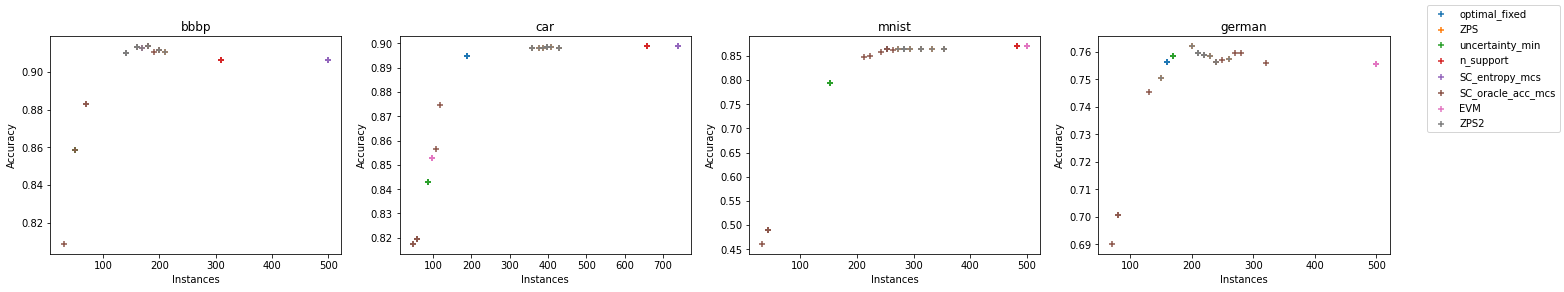

In [99]:
fig, ax = plt.subplots(1, len(perf.keys()), figsize=(24, 4))
for i, dataset in enumerate(perf.keys()):
    for ii, (method, result) in enumerate(perf[dataset].items()):
        ax[i].scatter(result[:,0], result[:,1], label=method if i == 0 else None, alpha=1, marker='+')
    ax[i].set_xlabel("Instances")
    ax[i].set_ylabel("Accuracy")
    ax[i].set_title(dataset)
fig.legend();

## Other models

In [2]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("bbbp", lambda: lru_cache()(bbbp)()),
        ("car", lambda: lru_cache()(car)()),
        ("mnist", lambda: lru_cache()(mnist)()),
        ("german", lambda: lru_cache()(german)()),
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear",
        "svm-poly",
        "svm-rbf",
        "random-forest",
        "gaussian-nb",
        "k-neighbors",
        #"perceptron", : Has no uncertainty output
        #"committee"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 0.01,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        #"aggregate": False
    }
}

In [3]:
capture_metrics = [
    accuracy_score,
    f1_score,
    roc_auc_score,
    
    "uncertainty_average",
    "uncertainty_min",
    "uncertainty_max",
    "uncertainty_variance",
    "uncertainty_average_selected",
    "uncertainty_min_selected",
    "uncertainty_max_selected",
    "uncertainty_variance_selected",
    "entropy_max",
    #"n_support", - SVM-only
    "contradictory_information",
    # slow, run this on the VM over the weekend!
    #"expected_error"
]

In [4]:
results = librun.run(matrix, metrics=capture_metrics)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

In [13]:
params = {
    "kappa": {"k": 2}
}
stop_conditions = {
    #f"{f.__name__}": partial(f, **params.get(f.__name__, {})) for f in [ZPS, uncertainty_min, n_support, optimal, optimal_ub, optimal_lb, SC_entropy_mcs, SC_oracle_acc_mcs, EVM, ]#kappa]
    **{f"{f.__name__}": partial(f, **params.get(f.__name__, {})) for f in [optimal_fixed, ZPS, uncertainty_min, SC_entropy_mcs, SC_oracle_acc_mcs, EVM]},
    "ZPS2": partial(ZPS, order=2)
}

In [14]:
stop_results = {}
for (clfs, (conf, metrics)) in zip(classifiers, results_plots):
    stop_results.setdefault(conf.dataset_name, {})
    stop_results[conf.dataset_name].setdefault(conf.model_name, {})
    
    for (name, cond) in stop_conditions.items():
        stop_results[conf.dataset_name][conf.model_name][name] = [cond(**metrics, classifiers=clfs_) for clfs_ in clfs]

In [19]:
metric = 'accuracy_score'
perf = {}

for i, dataset in enumerate(stop_results.keys()):
    perf[dataset] = {}
    for ii, model in enumerate(stop_results[dataset].keys()):
        perf[dataset][model] = {}
        for method in stop_results[dataset][model].keys():
            perf[dataset][model][method] = []
            for run in stop_results[dataset][model][method]:
                perf[dataset][model][method].append((run, results_plots[i*len(matrix['models'])+ii][1][metric][results_plots[i*len(matrix['models'])+ii][1].x==run]))

In [21]:
for dataset in stop_results.keys():
    for model in stop_results[dataset].keys():
        for method in stop_results[dataset][model].keys():
            perf[dataset][model][method] = np.array(perf[dataset][model][method])

<ipython-input-21-f27f4892c701>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  perf[dataset][model][method] = np.array(perf[dataset][model][method])


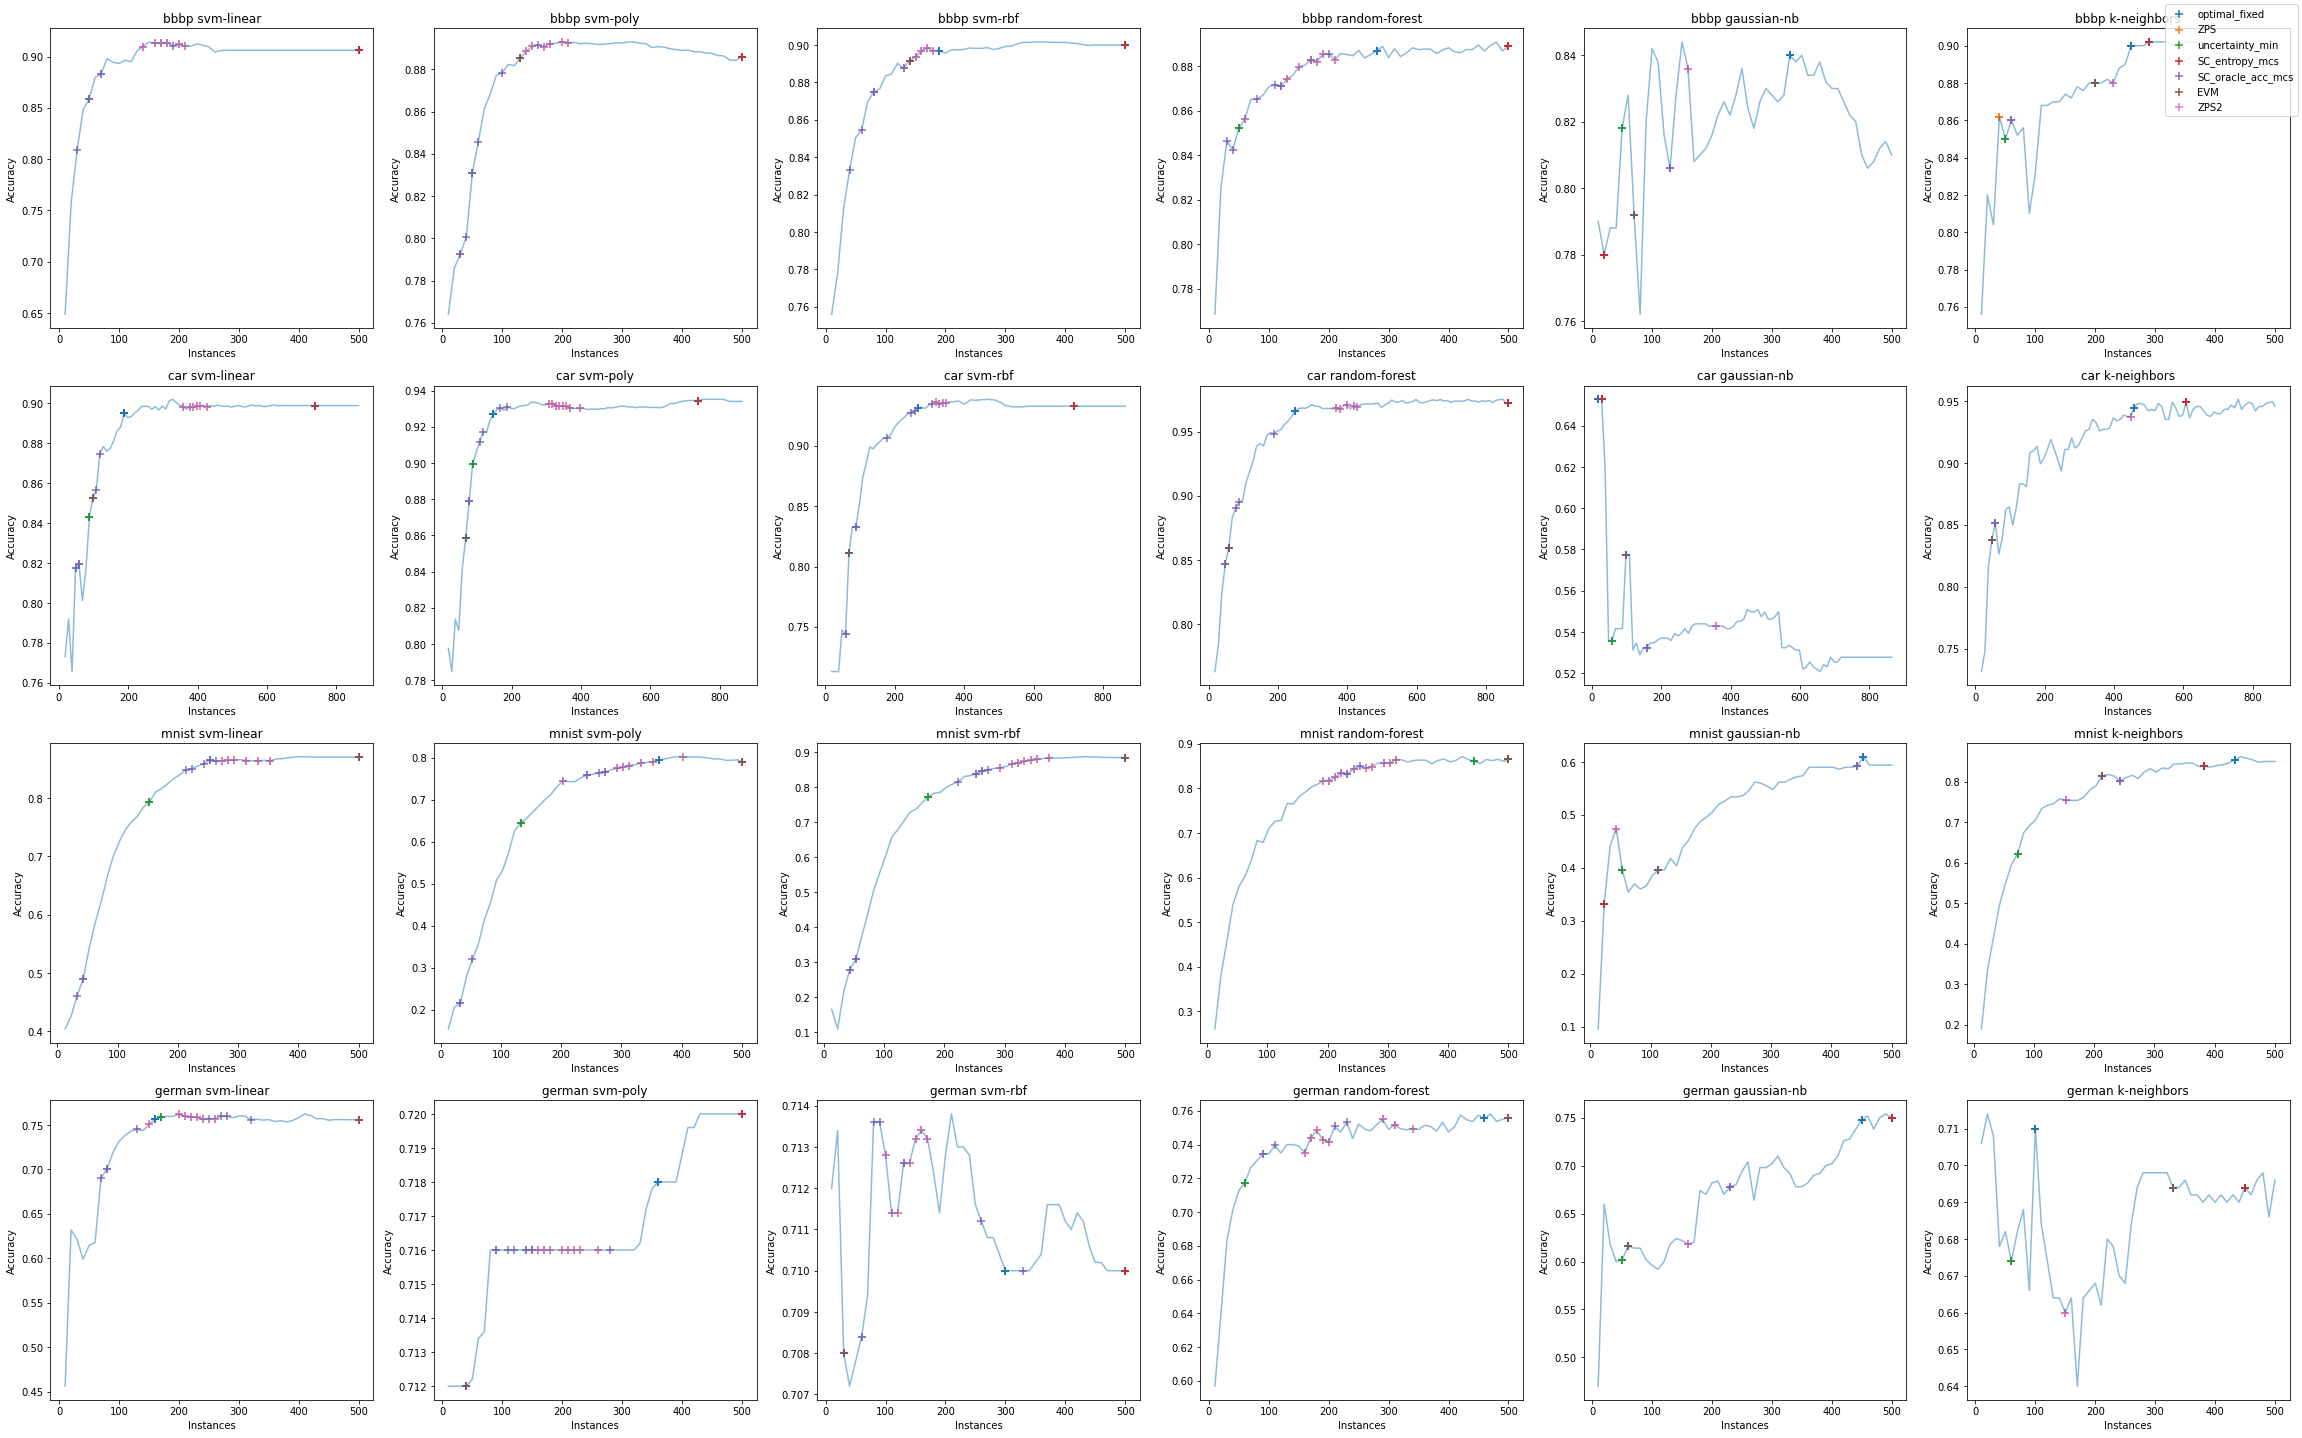

In [50]:
fig, axes = plt.subplots(len(perf.keys()), len(matrix['models']), figsize=(32, 20))
for ii, (dataset, axes) in enumerate(zip(list(perf.keys()), axes)):
    for i, (model, ax) in enumerate(zip(matrix['models'], axes)):
        for iii, (method) in enumerate(stop_conditions.keys()):
            ax.scatter(perf[dataset][model][method][:,0], perf[dataset][model][method][:,1], label=method if i == 0 and ii ==0 else None, alpha=1, marker='+', s=50)
        ax.plot(results_plots[i+ii*len(matrix['models'])][1].x, results_plots[i+ii*len(matrix['models'])][1].accuracy_score, alpha=0.5)
        ax.set_xlabel("Instances")
        ax.set_ylabel("Accuracy")
        ax.set_title(f"{dataset} {model}")
fig.tight_layout()
fig.legend();

## Observations

Performance is decent as long as the learning curve is consistent enough. Large dips in performance can trigger early stops, but in these cases it is not necessarilly clear if there is a good place to stop at all.

Gaussian-NB, k-neighbors, and occassionally svm-rbf suffer from this problem.

## Autorank

In [33]:
from autorank import autorank, plot_stats

In [4]:
help(autorank)

Help on function autorank in module autorank.autorank:

autorank(data, alpha=0.05, verbose=False, order='descending', approach='frequentist', rope=0.1, rope_mode='effsize', nsamples=50000, effect_size=None)
    Automatically compares populations defined in a block-design data frame. Each column in the data frame contains
    the samples for one population. The data must not contain any NaNs. The data must have at least five measurements,
    i.e., rows. The current version is only reliable for less than 5000 measurements.
    
    The following approach is implemented by this function.
    
    - First all columns are checked with the Shapiro-Wilk test for normality. We use Bonferoni correction for these
      tests, i.e., alpha/len(data.columns).
    - If all columns are normal, we use Bartlett's test for homogeneity, otherwise we use Levene's test.
    - Based on the normality and the homogeneity, we select appropriate tests, effect sizes, and methods for determining
      the confid

In [34]:
def rank_stop_conds(stop_results, metric, title=None, holistic_x=50):
    data = []
    # n instances data
    for i, dataset in enumerate(stop_results.keys()):
        for ii, method in enumerate(stop_results[dataset].keys()):
            if i == 0:
                data.append([])
            for run in stop_results[dataset][method]:
                if metric == "instances":
                    data[ii].append(run)
                elif metric == "holistic":
                    data[ii].append(
                        (results_plots[i][1].accuracy_score[results_plots[i][1].x==run].iloc[0]+results_plots[i][1].roc_auc_score[results_plots[i][1].x==run].iloc[0])/2*holistic_x*100-run
                    )
                else:
                    data[ii].append(results_plots[i][1][metric][results_plots[i][1].x==run].iloc[0])
    data = pd.DataFrame(np.array(data).T, columns=list(stop_results['car'].keys()))

    autoranked = autorank(data, order='ascending' if metric == 'instances' else 'descending')

    ax = plot_stats(autoranked)
    ax.figure.suptitle(title or metric.rsplit("_score")[0].replace("_", " ").title());
    return ax

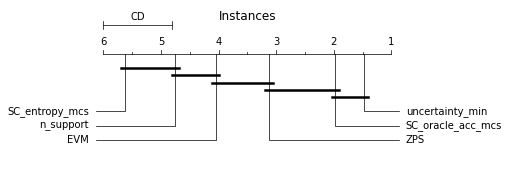

In [48]:
ax = rank_stop_conds(stop_results, "instances")
ax.figure.savefig('figures/stop_cond_instances.png')

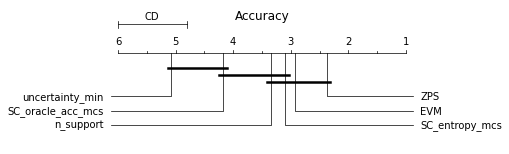

In [55]:
ax = rank_stop_conds(stop_results, "accuracy_score")
ax.figure.savefig('figures/stop_cond_accuracy.png')

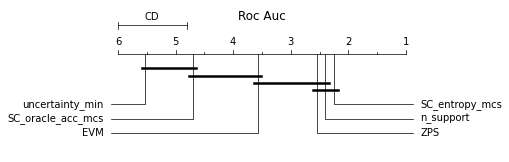

In [56]:
ax = rank_stop_conds(stop_results, "roc_auc_score")
ax.figure.savefig('figures/stop_cond_roc_auc.png')

In [58]:
# i.e. gaining 1% of averaged (accuracy, ROC AUC) is worth training on x=100 extra instances
interact(lambda x: rank_stop_conds(stop_results, "holistic", title=f"(acc+roc_auc)/2*{x}*100 - runs", holistic_x=x), x=widgets.IntSlider(76, 10,200, continuous_update=False));

interactive(children=(IntSlider(value=76, continuous_update=False, description='x', max=200, min=10), Output()…

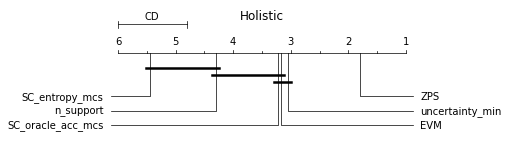

In [60]:
ax = rank_stop_conds(stop_results, "holistic", holistic_x=76)
ax.figure.savefig('figures/stop_cond_holistic.png')

## Expected error

In [20]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        #("bbbp", lambda: lru_cache()(bbbp)()),
        ("car", lambda: lru_cache()(car)()),
        ("mnist", lambda: lru_cache()(mnist)()),
        ("german", lambda: lru_cache()(german)()),
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 0.01,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        #"aggregate": False
    }
}

In [21]:
results = librun.run(matrix, metrics=capture_metrics, force_cache=True)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

In [26]:
reload(libstop); from libstop import ZPS, uncertainty_min, n_support, optimal, optimal_ub, optimal_lb, optimal_fixed, SC_entropy_mcs, SC_oracle_acc_mcs, acc, first_acc, EVM, kappa, kappa_metric, no_ahead_tvregdiff, hyperplane_similarity, ZPS_ee, SC_mes, ZPS_ee_grad, ZPS_ee_grad_sub

In [27]:
params = {
    "kappa": {"k": 2}
}
stop_conditions = {
    **{f"{f.__name__}": partial(f, **params.get(f.__name__, {})) for f in [uncertainty_min, SC_entropy_mcs, SC_oracle_acc_mcs, EVM, SC_mes, ZPS_ee_grad, ZPS_ee_grad_sub]},
    "ZPS2": partial(ZPS, order=2),
    "ZPS_ee": partial(ZPS_ee, threshold=2e-1)
}

stop_results = {}
for (clfs, (conf, metrics)) in zip(classifiers, results_plots):
    stop_results[conf.dataset_name] = {}
    for (name, cond) in stop_conditions.items():
        stop_results[conf.dataset_name][name] = [cond(**metrics, classifiers=clfs_) for clfs_ in clfs]

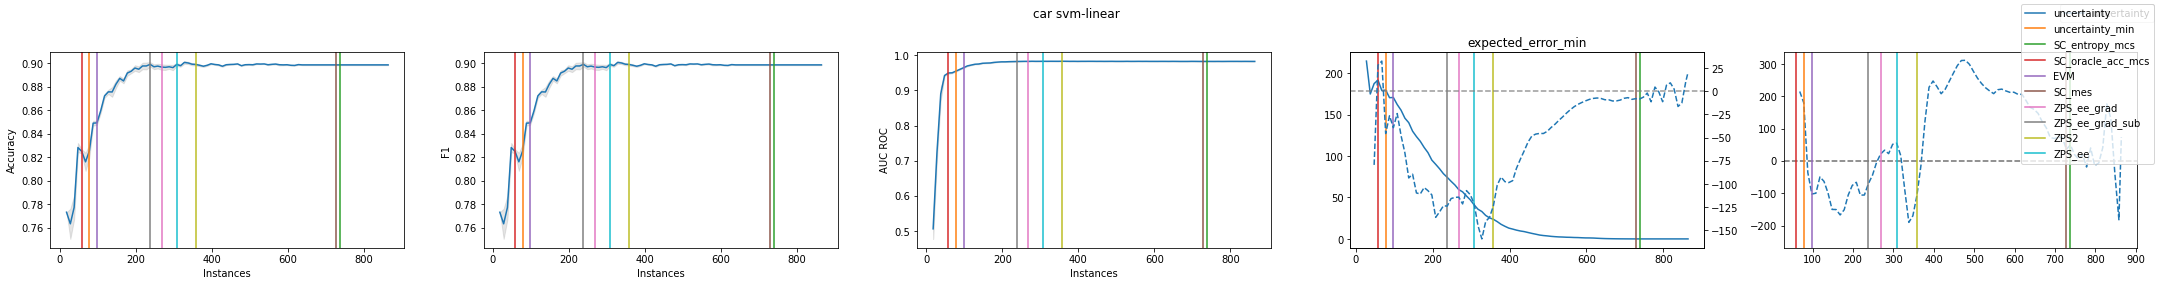

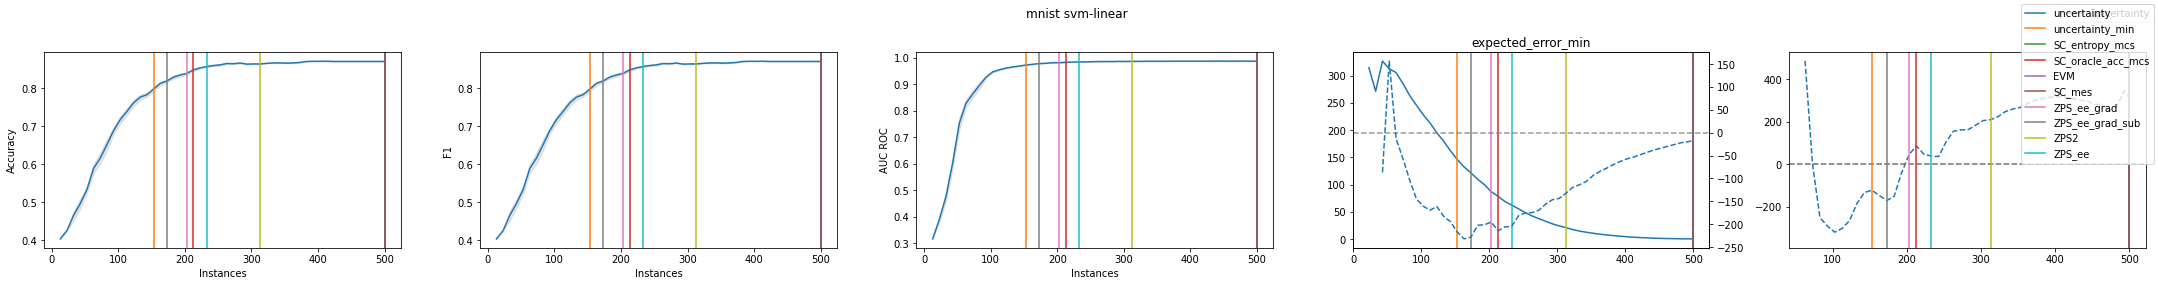

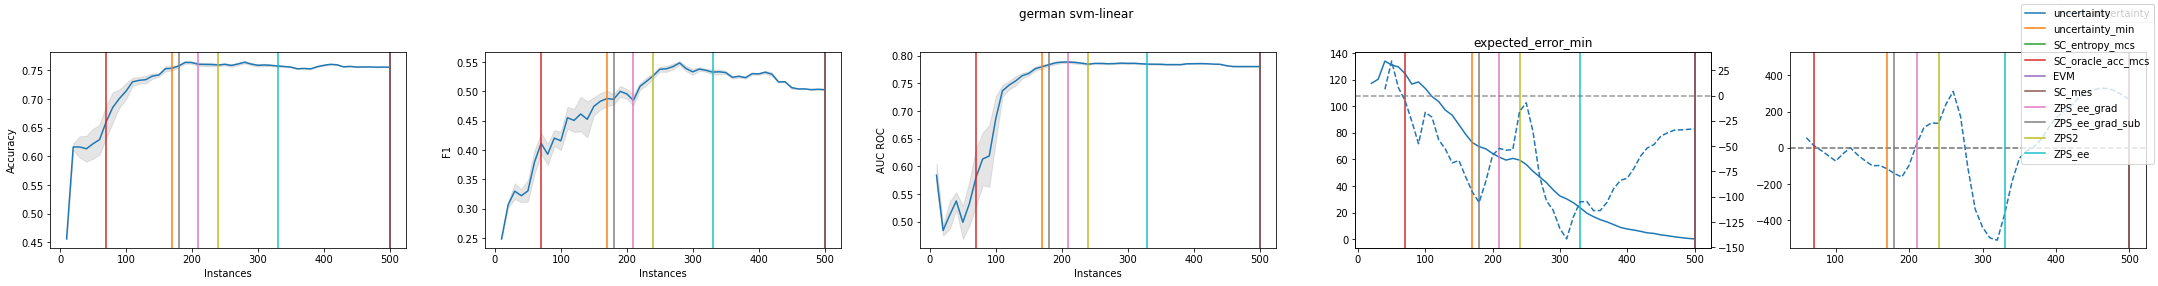

In [41]:
reload(libstop); reload(librun)
figaxes = librun.plot(results_plots, ret=True, sort=False, extra=2, figsize=(30,4))
for i, (fig, ax) in enumerate(figaxes):
    clfs = classifiers[i]
    metrics = results_plots[i][1]
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    accs = [first_acc(clfs_)[1] for clfs_ in clfs]
    accx = first_acc(clfs[0])[0]
    
    acc_median = np.median(accs, axis=0)
    acc_stderr = np.std(accs, axis=0)
    
    ax[-2].plot(metrics.x, metrics.expected_error_min)
    ax[-2].set_title("expected_error_min")
    
    ax2 = ax[-2].twinx()
    ax2.axhline(0, ls='--', color='grey', alpha=0.8)
    ax2.plot(metrics.x[1:], no_ahead_tvregdiff(metrics.expected_error_min[1:], 1, 1e-1, plotflag=False, diagflag=False), ls='--')
    
    ax[-1].axhline(0, ls='--', color='grey', alpha=0.8)
    ax[-1].plot(metrics.x[3:], no_ahead_tvregdiff(no_ahead_tvregdiff(metrics.expected_error_min[1:], 1, 1e-1, plotflag=False, diagflag=False)[2:], 1, 15, plotflag=False, diagflag=False), ls='--')
    ax[-1].axhline(0, ls='--', color='grey', alpha=0.8)
    
    
    align_yaxis(ax[-1], ax3)
    
    for ii, a in enumerate(ax):        
        for iii, (name, cond) in enumerate(stop_conditions.items()):
            stops = stop_results[results_plots[i][0].dataset_name][name]
            #a.axvline(np.median(stops), label=name if ii == 0 else None, color=colors[(iii+1)%len(colors)])
            #if name not in ["ZPS2", "SC_mes", "ZPS_ee"]:
            #    continue
            for iiii, stop in enumerate(stops[:1]):
                a.axvline(stop, label=name if ii == 0 and iiii ==0 else None, color=colors[(iii+1) % len(colors)])

    fig.legend()
    fig.tight_layout()

Third derivatives are unfortunately not useful here to reduce the probability of stopping on small dumps (as they were in ZPS2).
Instead I think it might be possible to tune the third derivative threshold by scaling on the maximum of the original expected error metric.
For now the threshold is fixed at >=10, we'll see how well that does I guess?

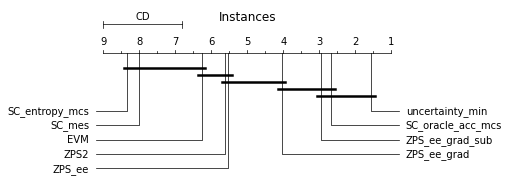

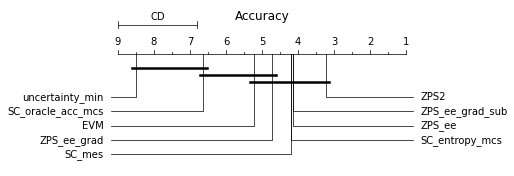

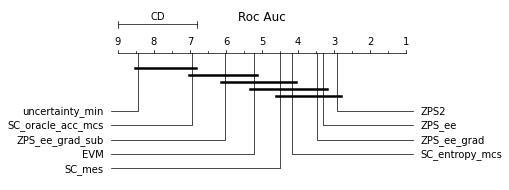

In [35]:
rank_stop_conds(stop_results, "instances")
rank_stop_conds(stop_results, "accuracy_score")
rank_stop_conds(stop_results, "roc_auc_score")

In [36]:
# i.e. gaining 1% of averaged (accuracy, ROC AUC) is worth training on x=100 extra instances
interact(lambda x: rank_stop_conds(stop_results, "holistic", title=f"(acc+roc_auc)/2*{x}*100 - runs", holistic_x=x), x=widgets.IntSlider(100, 10,200, continuous_update=False));

interactive(children=(IntSlider(value=100, continuous_update=False, description='x', max=200, min=10), Output(…

i.e. gaining 1% of averaged (accuracy, ROC AUC) is worth training on x=100 extra instances